# Article: [Predicting TCR-Epitope Binding Specificity Using Deep Metric Learning and Multimodal Learning](https://www.mdpi.com/2073-4425/12/4/572)

## **Objects**

#### *1. Develop a Computational Model: The paper aims to create a convolutional neural network model that utilizes deep metric learning and multimodal learning techniques to predict interactions between T cell receptors (TCRs) and Major Histocompatibility Complex class I-peptide complexes (pMHC).*

#### *2. Simultaneous TCR-Epitope Binding Prediction: The paper seeks to perform two critical tasks in TCR-epitope binding prediction: identifying the TCRs that bind a given epitope from a TCR repertoire and identifying the binding epitope of a given TCR from a list of candidate epitopes. The goal is to achieve accurate predictions for both tasks simultaneously.*

##### *3. Gain Insights into Binding Specificity: The paper aims to provide insights into the factors that determine TCR-epitope binding specificity, including the identification of key amino acid sequence patterns and positions within the TCR that are important for binding specificity. Additionally, the paper challenges the assumption that physical proximity to epitopes is the sole determinant of TCR-epitope specificity.*

## Packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
import matplotlib.pyplot as plt

2023-11-22 14:28:28.779362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 14:28:29.424903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-22 14:28:29.424931: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-22 14:28:29.501018: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 14:28:30.919625: W tensorflow/stream_executor/platform/de

## One-hot enocoding.

In [43]:
positives = pd.read_csv("./positive.csv")
negatives = pd.read_csv("./negative.csv")

amino_acids = []

def add_to_amino_acids(a_sequence: str):
    for acid in a_sequence:
        if acid not in amino_acids:
            amino_acids.append(acid)

positives.stack().reset_index(drop=True).apply(add_to_amino_acids)

amino_acids.sort()

amino_acid_label_encoder = LabelEncoder()
amino_acid_label_encoder.fit(amino_acids)

all_amino_acids = amino_acid_label_encoder.transform(amino_acids)

def feature_map(p_sequence):
    return [tf.one_hot(amino_acid_label_encoder.transform(list(x)), len(all_amino_acids)) for x in p_sequence]

data_cd3r = feature_map(positives["cdr3"])
data_epitope = feature_map(positives["antigen.epitope"])

## Data Representation

<center>
    <img src="gene.jpg" alt="Figure 1">
</center>

**Data Representation Goals:**

  1. Convert amino acid sequences from string format to a numeric representation.
  2. Develop a numerical procedure utilizing Atchley representation to capture physical and biochemical properties.
  3. Create matrices with specified dimensions through padding to accommodate varying sequence lengths.

### Sentence Construction with the Atchley Representation in both CDR3B and the Epitope
Fixed: Instead of constructing the sentences manually, I constructed the sentences utilizing the BertTokenizer in relateion to the amino_aciv_vocab.txt.

### Procedure encoding CDR3B and Eptiope Amino Acid Sequences as Numerical Matrices

### 2.2. CDR3B and Epitope Sequence Representation:



In [63]:
def convert_to_space_separated_string(series):
    return ' '.join(series)

tokenizer = BertTokenizer(vocab_file="./amino_acid_vocab.txt")

def construct_sentences(dataframe):
    cdr3_sentences = dataframe["cdr3"]
    epitope_sentences = dataframe["antigen.epitope"]
    return cdr3_sentences, epitope_sentences

def pad_sentences(sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.stack(input_ids), torch.stack(attention_masks)

def shuffle_data(data, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data)
    return data

def train_test_split_no_shuffle(data, test_size):
    split_index = int(len(data) * (1 - test_size))
    return data[:split_index], data[split_index:]
    
max_length = 32

positives = pd.read_csv("./positive.csv")

cdr3_sequence_epitope_encoder = LabelEncoder()
cdr3_sequence_epitope_encoder.fit(positives["antigen.epitope"])

cdr3_labels = cdr3_sequence_epitope_encoder.transform(positives["antigen.epitope"])
for column in positives.columns:
    positives[column] = positives[column].apply(convert_to_space_separated_string)

cdr3_sentences, epitope_sentences = construct_sentences(positives)

shuffle_data(cdr3_sentences, 42)
shuffle_data(epitope_sentences, 42)
shuffle_data(cdr3_labels, 42)

cdr3_input_ids, cdr3_attention_masks = pad_sentences(cdr3_sentences, max_length)
epitope_input_ids, epitope_attention_masks = pad_sentences(epitope_sentences, max_length)

cdr3_combined = torch.cat((cdr3_input_ids, cdr3_attention_masks), dim=1)
epitope_combined = torch.cat((epitope_input_ids, epitope_attention_masks), dim=1)


cdr3_train_data, cdr3_test_data = train_test_split_no_shuffle(cdr3_combined, test_size=0.2)
cdr3_labels_train_data, cdr3_labels_test_data = train_test_split_no_shuffle(cdr3_labels, test_size=0.2)
epitope_train_data, epitope_test_data = train_test_split_no_shuffle(epitope_combined, test_size=0.2)



cdr3_train_data = cdr3_train_data.transpose(0,1)
cdr3_test_data = cdr3_test_data.transpose(0,1)
epitope_train_data = epitope_train_data.transpose(0,1)
epitope_test_data = epitope_test_data.transpose(0,1)
cdr3_combined.shape

/tmp/ipykernel_21441/1479614054.py:32: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(data)


torch.Size([12735, 2, 32])

In [64]:
# leave only 10% of the labels in the data (just to test it)
unique = np.unique(cdr3_labels_train_data)
np.random.seed(42)
np.random.shuffle(unique) 
np.sort(unique)
the_labels = [np.where(cdr3_labels_train_data == x)[0] for x in unique[:int(len(unique) * 0.1)]]
the_labels = np.concatenate(the_labels)

cdr3_labels_train_data = cdr3_labels_train_data[the_labels]
cdr3_train_data[0] = cdr3_train_data[0][the_labels]
cdr3_train_data[1] = cdr3_train_data[1][the_labels]
# cdr3_labels_test_data = cdr3_labels_test_data[:int(len(cdr3_labels_test_data) * 0.1)]


RuntimeError: The expanded size of the tensor (10188) must match the existing size (351) at non-singleton dimension 0.  Target sizes: [10188, 32].  Tensor sizes: [351, 32]

In [59]:
cdr3_train_data.shape

(351, 64)

### Initialization of Training 

In [51]:
from transformers import *

config = BertConfig.from_json_file("./bert_config.json")

model = BertForMaskedLM(config=config) # change this line and flag what we're using

device = "cuda" if torch.cuda.is_available() else "cpu"

cdr3_train_data = cdr3_train_data.to(device)
cdr3_test_data = cdr3_test_data.to(device)
epitope_train_data = epitope_train_data.to(device)
epitope_test_data = epitope_test_data.to(device)

model.to(device)

# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\nModel's parameters:")
num_params = sum(p.numel() for p in model.parameters())
print(f'Total Parameters: {num_params}')

print("\nModel's parameters (only those that require gradients):")
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {num_trainable_params}')

print("\nModel's architecture:")
print(model)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

### Triplet Loss Function:
Article: [PyTorch Metric Learning](https://kevinmusgrave.github.io/pytorch-metric-learning/#:~:text=This%20customized%20triplet%20loss%20has,than%200.3%20will%20be%20discarded.)

In [6]:
# Testing the loss function...
loss_func = torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, reduction='mean')

#### Analyze the embedding between the CDR3 and the Epitope.

#### 1. BertForPreTraining


In [52]:
import torch
from transformers import BertTokenizer, BertForPreTraining, BertForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments, BertConfig

# Load the BERT tokenizer
config = BertConfig(
  hidden_size= 64,
  hidden_act= "gelu",
  initializer_range= 0.02,
  vocab_size= 25,
  hidden_dropout_prob= 0.1,
  num_attention_heads= 8,
  type_vocab_size= 2,
  max_position_embeddings= 64,
  num_hidden_layers= 3,
  intermediate_size= 64,
  attention_probs_dropout_prob= 0.1
)

model = BertForMaskedLM(config=config).to() # change this line and flag what we're using

In [53]:
%%time
steps = int(1e6)
X_train = cdr3_train_data
optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)
batch_size = 128
output_every_x_steps = 100
eval_every_x_steps = 100

def get_anchor_positive_index_negative_index(labels):
    random_label = np.random.choice(np.unique(labels))
    random_labels_we_want = labels[labels == random_label]
    negative_index = np.random.choice(np.where(labels != random_label)[0])
    indexs = (np.where(labels == random_label))[0]
    random_index_0 = None
    try:
        random_index_0 = np.random.choice(indexs)
    except ValueError:
        print(random_index_0, random_label, indexs)

    indexs = np.delete(indexs, np.where(indexs == random_index_0))
    if len(indexs) == 0:
        return random_index_0, random_index_0, negative_index
    random_index_1 = np.random.choice(indexs)
    return random_index_0, random_index_1, negative_index

def run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_train_data, cdr3_labels_train_data, loss_func):
    anchor_indexs = []
    positive_indexs = []
    negative_indexs = []

    for i in range(batch_size):
        anchor_index, positive_index, negative_index = get_anchor_positive_index_negative_index(cdr3_labels_train_data)
        anchor_indexs.append(anchor_index), positive_indexs.append(positive_index), negative_indexs.append(negative_index)
    # print(anchor_index, positive_index)
    # print(cdr3_train_data[0][anchor_index], cdr3_train_data[1][anchor_index])
    anchor_output = model(cdr3_train_data[0][anchor_indexs],cdr3_train_data[1][anchor_indexs])
    positive_output = model(cdr3_train_data[0][positive_indexs],cdr3_train_data[1][positive_indexs])
    negative_output = model(cdr3_train_data[0][negative_indexs],cdr3_train_data[1][negative_indexs])

    # Select anchor, positive, negative

    # 2. Calculate loss
    loss = loss_func(anchor_output[0], positive_output[0], negative_output[0])
    return loss

losses = []
test_losses = []
summed_loss = 0
summed_test_loss = 0
for step in range(steps):
    ### Training
    model.train() # train mode is on by default after construction
    
    # print(loss)

    # 3. Zero grad optimizer
    optimizer.zero_grad()
    loss = run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_train_data, cdr3_labels_train_data, loss_func)
    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()
    summed_loss += loss.detach().numpy()

    # ### Testing
    # if (step % (eval_every_x_steps) == 0) and step != 0:
    #     model.eval() # put the model in evaluation mode for testing (inference)
    #     with torch.inference_mode():
    #         test_loss = run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_test_data, cdr3_labels_test_data, loss_func)
    #     summed_test_loss += test_loss.detach().numpy()
    #     test_losses.append(test_loss.detach().numpy())
        
    losses.append(loss.detach().numpy())
    if step % output_every_x_steps == 0 and step != 0:
        print(f"Step: {step} | Train loss: {summed_loss / output_every_x_steps} | Test loss {summed_test_loss / (eval_every_x_steps)}")
        summed_loss = 0
        summed_test_loss = 0
plt.plot(losses)
plt.plot(test_losses)

IndexError: index 344 is out of bounds for axis 0 with size 32

In [12]:
# load the pytorch model in ./bert-pretrained/pytorch_model.bin

model.load_state_dict(torch.load("./bert-pretrained/pytorch_model.bin"))

<All keys matched successfully>

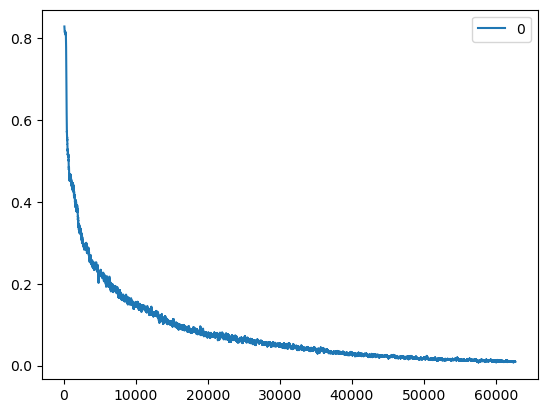

TypeError: no numeric data to plot

In [12]:
import pandas as pd

def plot_rolling_average_of_losses(losses, n_rolling_average = 100):
    df = pd.DataFrame(losses)
    df.rolling(n_rolling_average).mean().plot()
    plt.show()

# create rolling average 
plot_rolling_average_of_losses(losses, 100)
plot_rolling_average_of_losses(test_losses, 10)

In [13]:
embeddings = model(cdr3_train_data[0], cdr3_train_data[1])[0].detach().numpy() 

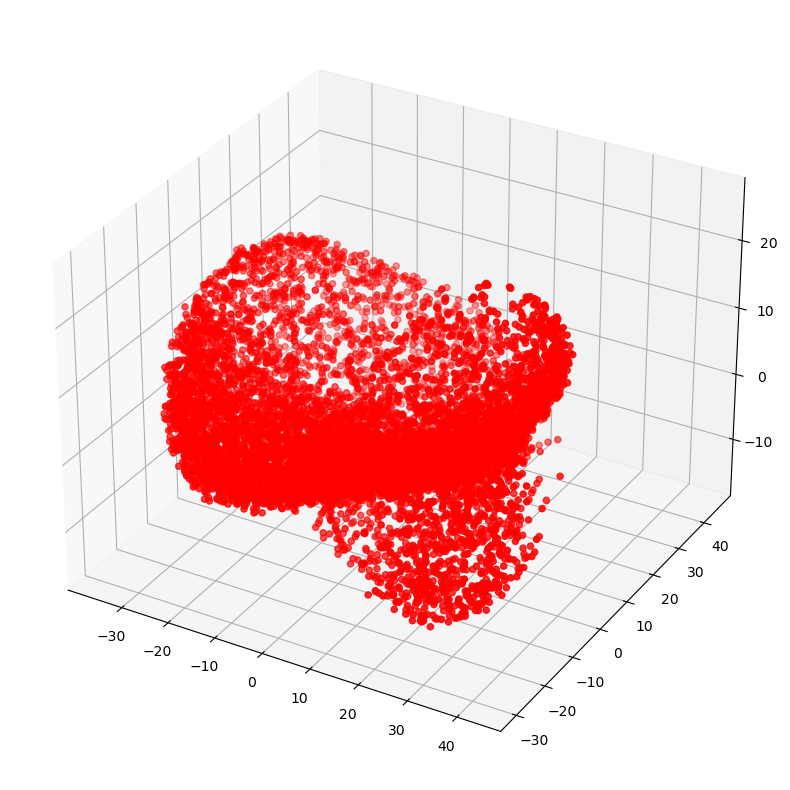

In [14]:
embeddings = embeddings.reshape(-1, 32 * 25)

# use pca
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

# plot a 3d plot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = pca_embeddings[:,0]
y = pca_embeddings[:,1]
z = pca_embeddings[:,2]

ax.scatter(x, y, z, c='r', marker='o')

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X = embeddings

# Assuming X is your matrix of data with samples as rows
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X)

X_labels = cdr3_labels_train_data

for unique_element in np.unique(X_labels):
    if unique_element not in X_labels:
        continue
    print(unique_element)
    X_subset = X[X_labels == unique_element]
    print(X_subset)
    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=np.random.uniform(1,3))

/home/matthandzel/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


21


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10188 but corresponding boolean dimension is 237

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

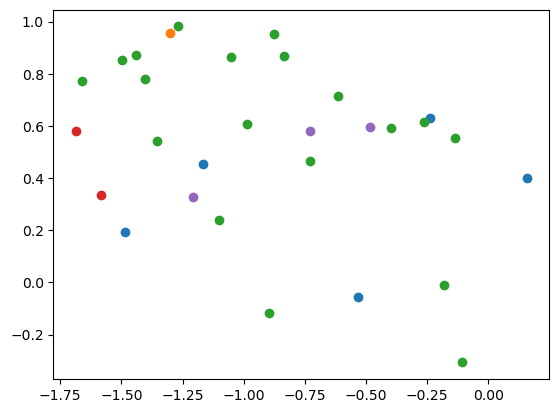

In [ ]:
# Find the 3 largest subsets of X_labels
unique_labels = np.unique(X_labels)
counts_of_labels = [len(np.where(X_labels == e)) for e in unique_labels]


biggest_labels = np.argsort(counts_of_labels)


for unique_element in unique_labels[biggest_labels[-5:]]:
    X_subset = X[X_labels == unique_element]
    plt.scatter(X_subset[:, 0], X_subset[:, 1])

In [56]:
model.save_pretrained("./bert-pretrained")

Configuration saved in ./bert-pretrained/config.json
Model weights saved in ./bert-pretrained/pytorch_model.bin


In [47]:
counts_of_labels[0]

1

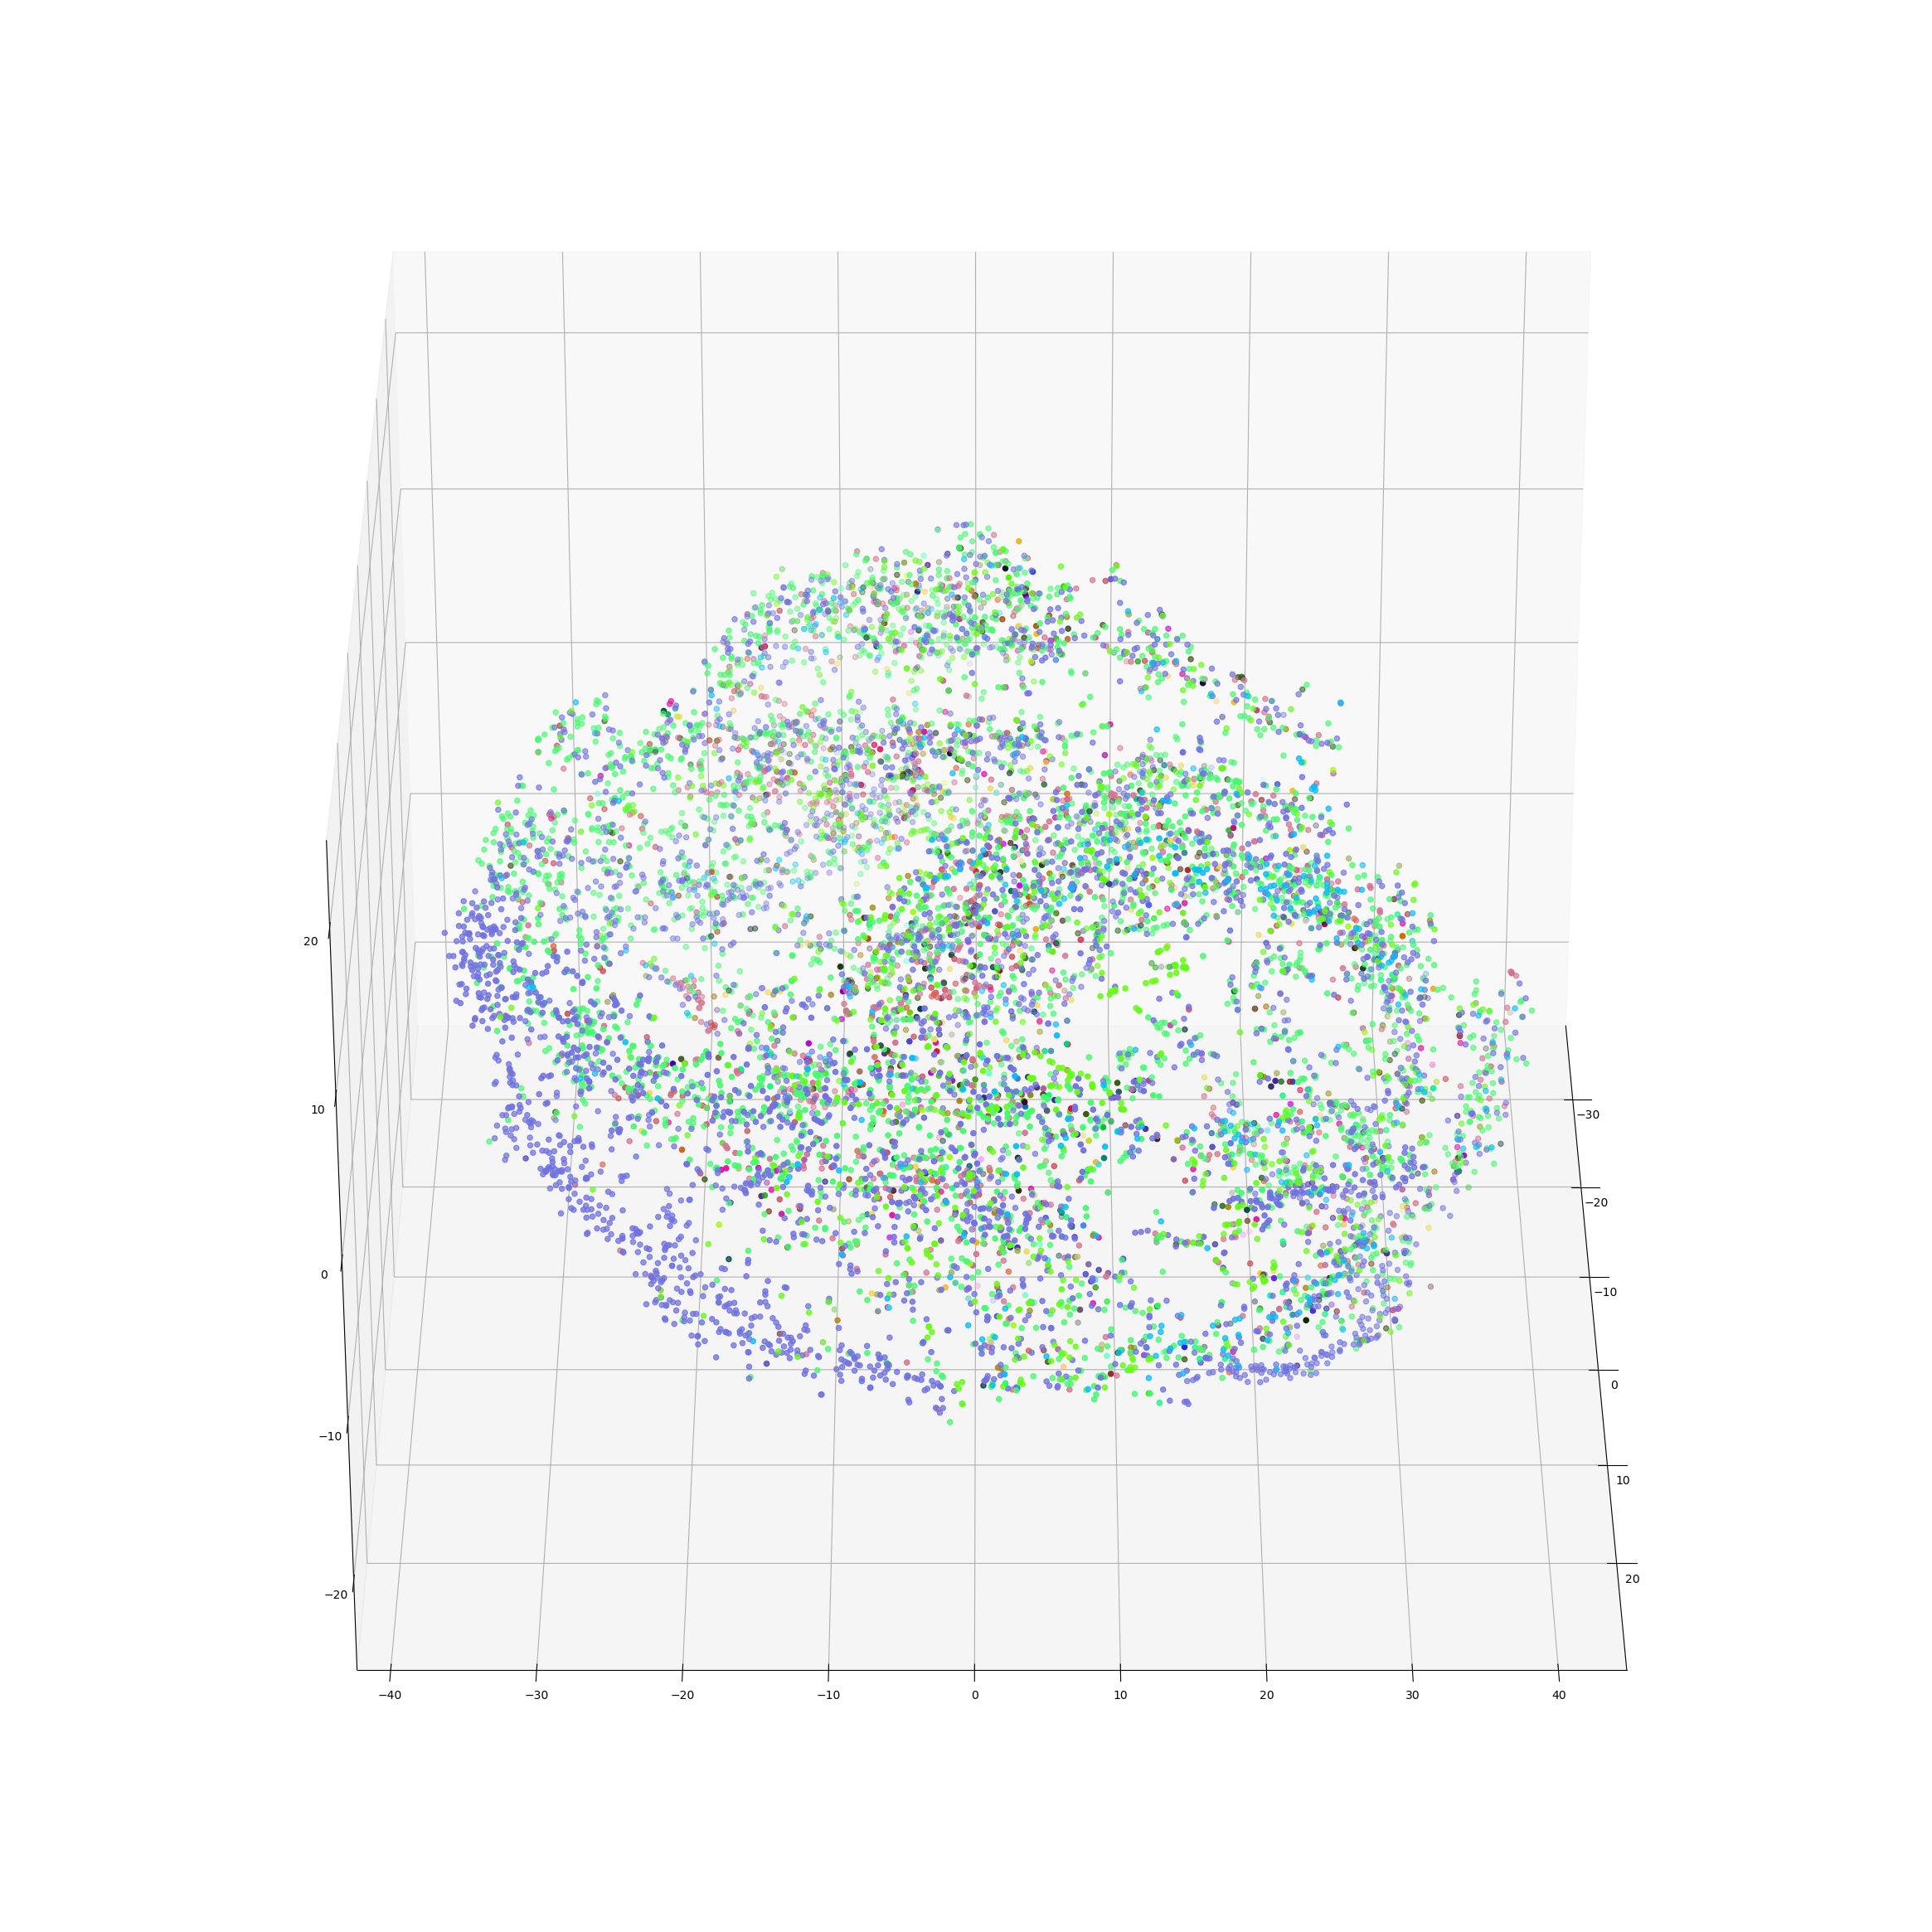

/tmp/ipykernel_841659/464529632.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("temp.png"))


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os

def create_3d_plot_and_save_as_gif(X, filename):
    # Create a figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D scatter plot
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])

    # Create a list to save the images
    images = []

    # Rotate the plot and save each angle as an image
    for angle in range(0, 360, 2):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

        # Save the current figure as an image
        fig.savefig("temp.png")
        images.append(imageio.imread("temp.png"))

    # Save the images as a GIF
    imageio.mimsave(filename, images)

    # Remove the temporary image
    os.remove("temp.png")

def create_3d_plot_and_save_as_gif(X, X_labels, filename):
    # Create a figure
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111, projection='3d')

    # # Create a 3D scatter plot
    # ax.scatter(X[:, 0], X[:, 1], X[:, 2])

    # Create a list to save the images
    images = []

    # Rotate the plot and save each angle as an image
    for angle in range(0, 360, 2):
        for unique_element in np.unique(X_labels):
            X_subset = X[X_labels == unique_element]
            ax.scatter(X_subset[:, 0], X_subset[:, 1], X_subset[:, 2], c=np.random.rand(1,3))
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

        # Save the current figure as an image
        fig.savefig("temp.png")
        images.append(imageio.imread("temp.png"))

    # Save the images as a GIF
    imageio.mimsave(filename, images)

    # Remove the temporary image
    os.remove("temp.png")

# Assuming X is your 3D data
create_3d_plot_and_save_as_gif(X_tsne, cdr3_labels_train_data, '3d_plot.gif')

#### 2. BertForMaskedLM


#### 3. BertForNextPrediction